In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from PIL import Image
import cv2

In [2]:
import random
import colorsys
import itertools
from colormath.color_objects import LabColor
from colormath.color_diff import delta_e_cie2000

def generate_random_colors(num_colors=100):
    """生成指定数量的随机RGB颜色"""
    return [generate_random_color() for _ in range(num_colors)]

def generate_random_color():
    """生成一个随机的RGB颜色"""
    hue = random.uniform(0, 360)
    saturation = random.uniform(0.3, 1)
    value = random.uniform(0.3, 1)
    r, g, b = colorsys.hsv_to_rgb(hue/360, saturation, value)
    return tuple(int(c * 255) for c in (r, g, b))

def find_max_distinct_colors(colors, num_colors=10):
    # 转换为Lab颜色空间
    lab_colors = [LabColor(*rgb_color, illuminant='D50') for rgb_color in colors]

    # 找到距离最大的两个颜色
    max_distance = 0
    max_indexes = None
    for indexes in itertools.combinations(range(num_colors), 2):
        distance = delta_e_cie2000(lab_colors[indexes[0]], lab_colors[indexes[1]])
        if distance > max_distance:
            max_distance = distance
            max_indexes = indexes

    selected_indexes = set(max_indexes)

    # 选出距离最大的10个颜色
    while len(selected_indexes) < num_colors:
        distances = []
        for i in range(len(colors)):
            if i not in selected_indexes:
                min_distance = float('inf')
                for j in selected_indexes:
                    distance = delta_e_cie2000(lab_colors[i], lab_colors[j])
                    min_distance = min(min_distance, distance)
                distances.append((min_distance, i))

        distances.sort(reverse=True)
        selected_indexes.add(distances[0][1])

    return [colors[i] for i in selected_indexes]

In [3]:
colors = generate_random_colors(10)

In [4]:
# 获取labels、语义图和mask边缘图列表
def get_semantic_edges(mask, colors):
    chosen_labels = np.unique(mask) # 去除其中重复的元素
    chosen_colors = [colors[label] for label in chosen_labels]
    contours_list = []
    # 新建一个图
    color_masks = np.zeros((mask.shape[0],mask.shape[1],3))
    for i,label in enumerate(chosen_labels):
        idx = np.nonzero(mask == label)
        color_masks[idx[0],idx[1]] = chosen_colors[i]  # 填图
        # get contours
        new_mask = np.zeros((mask.shape[0],mask.shape[1]))
        new_mask[idx[0],idx[1]] = 255
        contours,_ = cv2.findContours(new_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_list.append(contours)
    color_masks = color_masks.astype('uint8')
    color_masks = cv2.cvtColor(color_masks, cv2.COLOR_RGBA2BGR)
    return chosen_labels, color_masks, contours_list

In [328]:
# 一个聚类问题明显的例子
dir_ = "panda"
inv = "_inv"
inv = ""
feature_maps_path = f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/{dir_}{inv}"
feature_type = "input_block" # 1 2 4 5 7 8 10 11
feature_type = "output_block" # 0 1 2 up 3 4 5 up 6 7 8 up 9 10 11 
# block idx
# pos = "in"
pos = "out"
block_idx = 8
i = 18

# feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_layers_features_time_{i}.pt"))[0]
# feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_self_attn_time_{i}.pt"))[0]
feature_map = torch.load(os.path.join(feature_maps_path, f"{feature_type}_{block_idx}_{pos}_trans_time_{i}.pt"))[0]
feature_map_np = feature_map.cpu().numpy()
print(feature_map_np.shape)
if len(feature_map_np.shape) == 3:
    c,h,w = feature_map_np.shape
    feature_flatten = feature_map_np.reshape((c,-1)).T
else:
    feature_flatten = feature_map_np

(672, 640)


In [338]:
pca = PCA(n_components=3)
pca.fit(feature_flatten)
feature_flatten_pca = pca.transform(feature_flatten)
print(feature_flatten_pca.shape)

(672, 3)


In [339]:
n_clusters = 4
cluster = KMeans(n_clusters=n_clusters, init='k-means++').fit(feature_flatten)
# cluster = DBSCAN(eps=5, min_samples=9).fit(feature_flatten)
# cluster = SpectralClustering(n_clusters=n_clusters, random_state=0).fit(feature_flatten)


# 找到相互之间差异最大的10个颜色
result = find_max_distinct_colors(colors, n_clusters)
for idx, color in enumerate(result):
    print(f"第{idx+1}个颜色：{color}")

feature_cls = cluster.labels_.reshape((h,w))


_,vis,_ = get_semantic_edges(feature_cls, result)

/home/yfyuan/anaconda3/envs/v2v/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


第1个颜色：(134, 149, 204)
第2个颜色：(14, 40, 108)
第3个颜色：(83, 193, 82)
第4个颜色：(243, 93, 78)


block_idx 8, pos out, step 18 


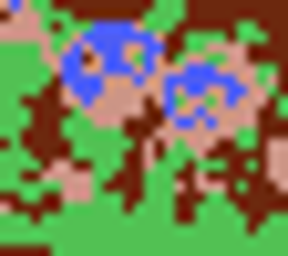

In [340]:
h,w,c = vis.shape
print(f"block_idx {block_idx}, pos {pos}, step {i} ")
display(Image.fromarray(vis).resize((576 // 2, 512 // 2)))

block_idx 7, pos out, step 5 


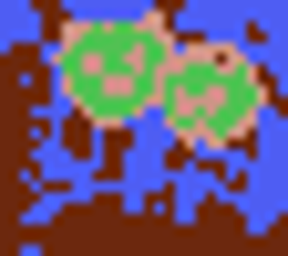

In [324]:
h,w,c = vis.shape
print(f"block_idx {block_idx}, pos {pos}, step {i} ")
display(Image.fromarray(vis).resize((576 // 2, 512 // 2)))

In [231]:
img_path = f"/home/yfyuan/YYF/Rerender/exp/ImageNet/imagenet-r/panda/misc_57.jpg"
import torchvision.transforms as transformers

In [304]:
frame = cv2.imread(img_path)
print(frame.shape)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = np.array(transformers.CenterCrop((frame.shape[0] // 64 * 64, frame.shape[1] // 64 * 64))(Image.fromarray(frame)))
background = Image.fromarray(frame)

(418, 500, 3)


In [325]:
alpha = 0.8
foreground = Image.fromarray(vis).resize((448,384))

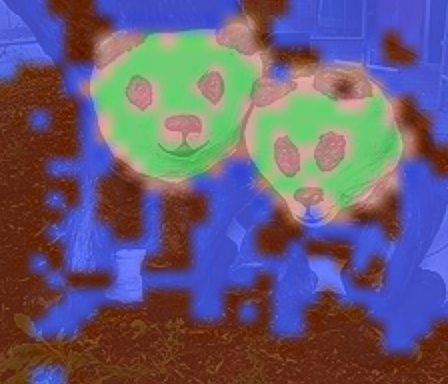

In [326]:
result = Image.blend(background, foreground, alpha)
display(result)

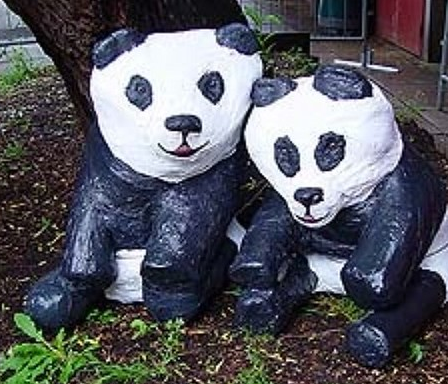

In [327]:
display(background)

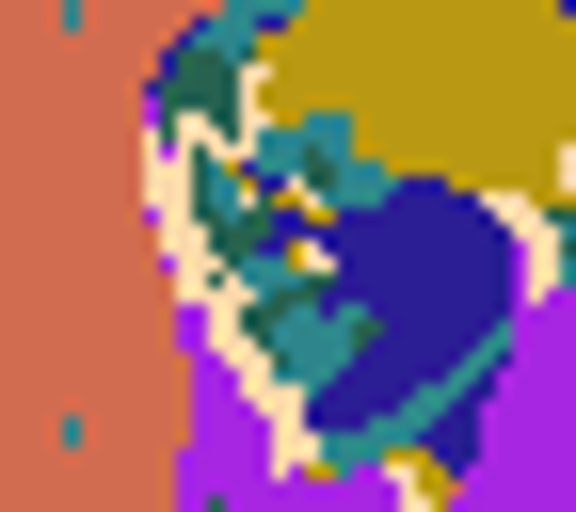

In [1297]:
h,w,c = vis.shape
display(Image.fromarray(vis).resize((576, 512)))

In [1116]:
cluster.labels_

array([4, 4, 0, ..., 0, 0, 4], dtype=int32)

In [131]:
res = TSNE(n_components=2, init='pca', random_state=0).fit_transform(X)

In [117]:
cluster = KMeans(n_clusters=n_clusters,random_state=0).fit(res)

/home/yfyuan/anaconda3/envs/v2v/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


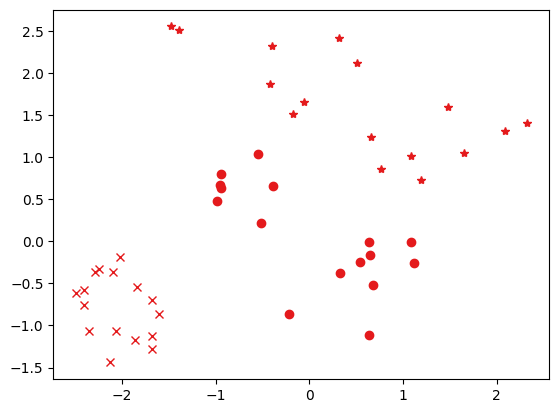

In [411]:
fig = plt.figure()
ax = plt.subplot(111)
for x,y in zip(res, Y):
    if(y==1):
        type_ = "o"
        label = "hair"
    elif (y==2):
        type_ = "x"
        label = "skin"
    else:
        type_ = "*"
        label = "shadow"
    plt.plot(x[0], x[1], str(f"{type_}"),
             color=plt.cm.Set1(1 / 10), label=label)  # 字体和大小

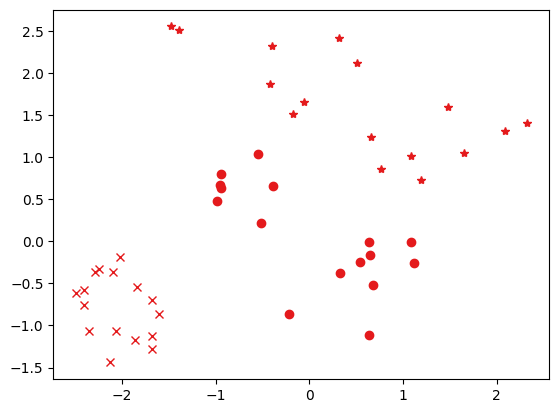

In [132]:
fig = plt.figure()
ax = plt.subplot(111)
for x,y in zip(res, Y):
    if(y==1):
        type_ = "o"
        label = "hair"
    elif (y==2):
        type_ = "x"
        label = "skin"
    else:
        type_ = "*"
        label = "shadow"
    plt.plot(x[0], x[1], str(f"{type_}"),
             color=plt.cm.Set1(1 / 10), label=label)  # 字体和大小